In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

import sys; sys.path.insert(0, '..') # add parent folder path where discrepancies folder is

from discrepancies import datasets, pool, pool2graph, evaluation, discrepancies_intervals, pool2graph_cat_FJ2_2

RANDOM_STATE = 42

import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
### Get data and fit a pool of classifiers on it

#X_train, X_test, y_train, y_test, scaler, feature_names, target_names, cat_names = datasets.get_dataset(dataset='adult-cat')
X_train, X_test, y_train, y_test, scaler, feature_names, target_names, cat_names = datasets.get_dataset(dataset='boston', test_size=0.26)

print(X_train.shape, y_train.mean())
cont_names = list(set(feature_names) - set(cat_names))

(374, 13) 0.5748663101604278


[15:32:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracies (F1):  {'SVMrbf': 0.9404761904761905, 'XGB': 0.9411764705882352}
Discrepancies on train: 0.10695187165775401
Discrepancies on test: 0.09090909090909091


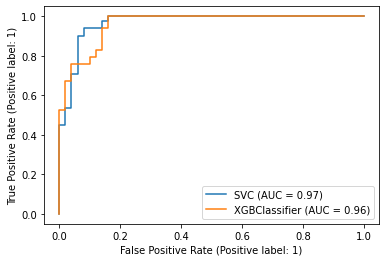

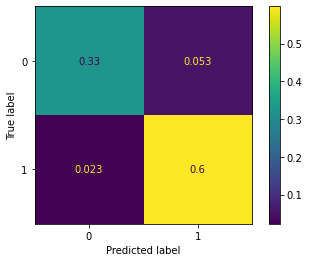

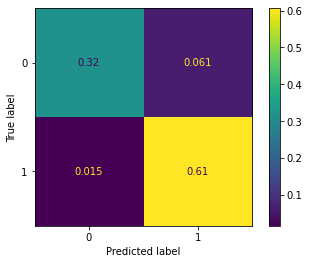

TypeError: where() missing 1 required positional argument: 'condition'

In [10]:
pool1 = pool.BasicPool()
pool1 = pool1.fit(X_train, y_train)

preds = pool1.predict(X_test)
from sklearn.metrics import f1_score

print("Accuracies (F1): ", {c: f1_score(y_test, preds[c]) for c in preds.columns})
print("Discrepancies on train:", pool1.predict_discrepancies(X_train).mean())
print("Discrepancies on test:", pool1.predict_discrepancies(X_test).mean())

from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve, plot_confusion_matrix


classifiers = [pool1.models["SVMrbf"], pool1.models["XGB"]]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax)

    
#plot_roc_curve(pool1.models["SVMrbf"], X_test, y_test)
#plot_roc_curve(pool1.models["RF200"], X_test, y_test)

plot_confusion_matrix(classifiers[0], X_test, y_test, normalize='all')
plt.show()
plot_confusion_matrix(classifiers[1], X_test, y_test, normalize='all')
plt.show()

errors1 = np.where()
print("Common errors", 1)


In [11]:
%%time 

p2g = pool2graph_cat_FJ2_2.pool2graph(X_train, y_train, pool1, k_init=100, categorical_names=cat_names)
#p2g = pool2graph.pool2graph(X_train, y_train, pool1, k_init=3)

p2g.fit(max_epochs=5)#5?
print(len(p2g.G.nodes))

INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5


158192


In [12]:
from discrepancies import discrepancies_intervals
intervals = discrepancies_intervals.get_discrepancies_intervals(p2g.G)
print(len(intervals))

49301


# Global analysis of the intervals

In [18]:
%load_ext autoreload

%autoreload 2
from discrepancies import analysis_global

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
### we work with that    
gda = analysis_global.GlobalDiscrepancyAnalyzer(p2g, pool1, intervals, X_train, cat_names)

NameError: name 'analysis_global' is not defined

### Most problematic features

For now, we evaluate separately the uncertainty associated to each feature for continuous and categorical features.
- For continuous features: Average range of the discrepancy interval along the feature
- For categorical features: proportion of intervals generated along the feature, normalized by the exposition in Xtrain --> pas sûr qu'il faille normaliser par ça... car intercalle = 2 pts, X_train= chaque pt


In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

feat_imp = gda.get_global_discrepancy_importances(min_expo=10)
#fname = '../../results/feature_importances_adult.pdf'
gda.plot_feature_importances(palettes=['mako', 'mako'])#, savefig='')

In [ ]:
plt.figure(figsize=(len(feat_imp['continuous_features'])/2,4))
plt.xticks(rotation=70, fontsize=10)
sns.barplot(data=pd.DataFrame(feat_imp['continuous_features']).T, palette="mako")
#plt.title(" features")
plt.tight_layout()
#plt.savefig("./../../results/usecase_boston_featimp_cont.pdf")
plt.show()

## Important areas of discrepancy

In [187]:
%%time
gda.get_discrepancy_segments(X_exposition=X_train, y_exposition=y_train, min_expo=0.05, min_purity=0.5, min_purity_expo=0.0)



Discrepancy segments tree accuracy on nodes: 0.5125211875991033
... on exposition data 0.29787234042553196
====== SEGMENT 4 ======
=== Segment description:
decision node 0 : LSTAT <= -0.04102504439651966)
decision node 1 : RM <= 0.21231143921613693)
decision node 2 : RAD <= -0.413443461060524)
decision node 3 : PTRATIO <= -0.37967176735401154)
=== Segment characteristics
Segment exposition: 0.06324110671936758
Segment node population (proxy for size?): 0.11489404138618799
Percent of the discrepancy nodes contained here: 0.1451251078515962
Segment purity: 0.5109799496571478
Segment purity (X_expo): 0.3125
Accuracy of classifiers (F1 on X_expo) on segment: {'SVMrbf': 0.7058823529411765, 'XGB': 1.0}
====== SEGMENT 8 ======
=== Segment description:
decision node 0 : LSTAT <= -0.04102504439651966)
decision node 1 : RM <= 0.21231143921613693)
decision node 2 : RAD > -0.413443461060524)
=== Segment characteristics
Segment exposition: 0.05928853754940711
Segment node population (proxy for size

In [ ]:
print("svm", f1_score(y_test, pool1.predict(X_test).iloc[:, 0]))
print("xgb", f1_score(y_test, pool1.predict(X_test).iloc[:, 1]))

def ensemble_segment(X, segments=[]):
    leaves = gda.segments_tree.apply(X)
    
    for leaf_index in segments:
        segments_index = np.where(leaves == leaf_index)
        
        
        

CPU times: user 1min 45s, sys: 1.93 s, total: 1min 46s
Wall time: 9.25 s


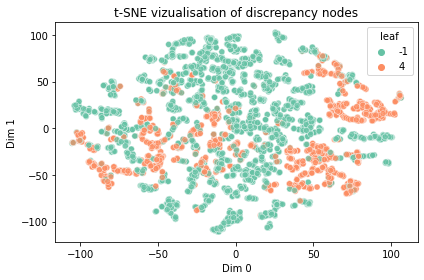

In [171]:
%%time

LEAVES_SEGMENTS = (4,5)

data = gda.disc_nodes_dataset.sample(n=5000)
leaves_data = gda.segments_tree.apply(data)
leaves_data_rearr = np.array([ld if ld in LEAVES_SEGMENTS else -1 for ld in leaves_data])

colors = list(sns.color_palette("Set2", n_colors=len(set(leaves_data))))

from sklearn.manifold import TSNE
tsne = TSNE(perplexity=10, n_jobs=-1).fit_transform(data)
tsne = pd.DataFrame(tsne, columns=["Dim 0", "Dim 1"])
tsne['leaf'] = leaves_data_rearr
#tsne["cluster"] = clusters
sns.scatterplot(x="Dim 0", y="Dim 1", data=tsne, hue="leaf", palette="Set2", alpha=0.7)#, c=[colors[i] for i in leaves_data_rearr.values])
plt.title("t-SNE vizualisation of discrepancy nodes")
#plt.legend()
plt.tight_layout()
#plt.savefig("./../../results/discussion_tsne_boston.pdf")

In [ ]:
self

In [56]:
plt.savefig("./../../results/discussion_tsne_boston.pdf")

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='Dim 0', ylabel='Dim 1'>

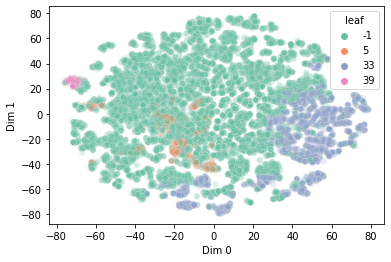

In [25]:
sns.scatterplot(x="Dim 0", y="Dim 1", data=tsne, hue="leaf", palette="Set2", alpha=0.1)#, c=[colors[i] for i in leaves_data_rearr.values])

In [3]:
pool1.predict(X_test)



NameError: name 'pool1' is not defined

In [12]:
pool1.predict_discrepancies(X_test).mean

0.07894736842105263

# TODO
- Categorical: quand on génère les faux jumeaux, garder en mémoire les couples des modalités: blond-brun, et le changement associé?
- TSNE: couleurs 
- relative size: devrait être nombre de noeuds de discrepancy dans la feuille sur le nombre de noeuds de discrepancy